In [1]:
!pip install requests pandas python-dotenv spacy
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os

# Store your Jira credentials
JIRA_EMAIL = ""
JIRA_API_TOKEN = ""
JIRA_DOMAIN = ""
PROJECT_KEY = ""

In [3]:
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth

# Construct the API URL and headers
url = f"https://{JIRA_DOMAIN}/rest/api/3/search"
headers = {"Accept": "application/json"}
auth = HTTPBasicAuth(JIRA_EMAIL, JIRA_API_TOKEN)

# Search query to get issues from your project
params = {
    "jql": f"project={PROJECT_KEY}",
    "fields": "summary,description,priority,created,duedate",
    "maxResults": 100
}

# Make the API call
response = requests.get(url, headers=headers, params=params, auth=auth)

# Check for successful response
if response.status_code == 200:
    issues = response.json().get("issues", [])
else:
    raise Exception(f"Failed to fetch issues: {response.status_code} - {response.text}")

# Parse the issues into a DataFrame
data = []
for issue in issues:
    fields = issue["fields"]
    data.append({
        "id": issue["id"],
        "summary": fields.get("summary"),
        "description": fields.get("description"),
        "priority": fields.get("priority", {}).get("name"),
        "created": fields.get("created"),
        "duedate": fields.get("duedate")
    })

df = pd.DataFrame(data)
df.head()

,id,summary,description,priority,created,duedate
0,10003,(Sample) Create Donation Page,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-15T10:56:44.773+0530,None
1,10002,(Sample) Create User Registration Form,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-15T10:56:44.747+0530,None
2,10004,(Sample) Email Verification Process,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-15T10:56:44.736+0530,None
3,10005,(Sample) Donation History Tracking,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-15T10:56:44.736+0530,None
4,10000,(Sample) User Registration,"{'type': 'doc', 'version': 1, 'content': [{'ty...",Medium,2025-05-15T10:56:43.525+0530,2025-05-22


**Data Collection**

Fetch All Issues from Apache Hadoop JIRA

In [4]:
import requests
import pandas as pd
import time

all_issues = []
start_at = 0
max_results = 100
total = 1  # initial dummy value to enter loop

while start_at < total:
    url = "https://issues.apache.org/jira/rest/api/2/search"
    params = {
        "jql": "project=HADOOP",
        "fields": "summary,description,priority,status,created",
        "startAt": start_at,
        "maxResults": max_results
    }

    response = requests.get(url, params=params)
    data = response.json()
    issues = data.get("issues", [])
    total = data.get("total", 0)

    for issue in issues:
        f = issue["fields"]
        all_issues.append({
            "summary": f.get("summary", ""),
            "description": f.get("description", ""),
            "priority": f.get("priority", {}).get("name", ""),
            "status": f.get("status", {}).get("name", ""),
            "created": f.get("created", "")
        })

    start_at += max_results
    time.sleep(0.5)  # Be polite and avoid rate limits

# Convert to DataFrame
df = pd.DataFrame(all_issues)
df.to_csv("hadoop_issues_full.csv", index=False)
print(f"Fetched {len(df)} issues.")

Fetched 17257 issues.


**Load and Inspect the Data**

In [5]:
import pandas as pd

df = pd.read_csv("hadoop_issues_full.csv")
print(f"Total issues: {df.shape[0]}")
df.head()

Total issues: 17257


,summary,description,priority,status,created
0,S3A: ITestS3AConfiguration.testDirectoryAlloca...,while working on HADOOP-19554 I added a per-bu...,Minor,Open,2025-05-20T13:59:50.000+0000
1,ABFS: [FnsOverBlob] Empty Page Issue on Subseq...,We came across a new behavior from server wher...,Major,Open,2025-05-20T06:14:55.000+0000
2,Improve PrometheusMetricsSink#normalizeName pe...,This patch is similar from HDDS-13014. We can ...,Major,Open,2025-05-17T05:57:56.000+0000
3,Upgrade libxxhash to 0.8.3 in Windows 10,The current version of libxxhash - 0.8.1 isn't...,Major,Resolved,2025-05-16T04:02:04.000+0000
4,S3A: stream write/close fails badly once FS is...,"when closing a process during a large upload, ...",Minor,In Progress,2025-05-14T16:35:33.000+0000


**Drop Nulls and Duplicates**

In [6]:
df.dropna(subset=["summary", "priority"], inplace=True)
df.drop_duplicates(inplace=True)

**Map Priority to ML Labels (High / Medium / Low)**

In [7]:
def map_priority(p):
    p = str(p).lower()
    if p in ["blocker", "critical"]:
        return "High"
    elif p == "major":
        return "Medium"
    else:
        return "Low"

df["priority_level"] = df["priority"].apply(map_priority)
df["priority_level"].value_counts()

,count
priority_level,
Medium,11137
Low,4324
High,1796


**Install & Load spaCy for Text Preprocessing**

In [8]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Clean and Lemmatize Summary & Description Text**

In [9]:
# Define cleaning function
def clean_text(text):
    if not isinstance(text, str): return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])

# Apply cleaning to summary and description
df["clean_summary"] = df["summary"].apply(clean_text)
df["clean_description"] = df["description"].fillna("").apply(clean_text)

# Preview cleaned dataset
df_cleaned_preview = df[["summary", "clean_summary", "description", "clean_description", "priority", "priority_level"]]
df_cleaned_preview.head(10)

,summary,clean_summary,description,clean_description,priority,priority_level
0,S3A: ITestS3AConfiguration.testDirectoryAlloca...,fail,while working on HADOOP-19554 I added a per-bu...,work add bucket setting fail test run entire c...,Minor,Low
1,ABFS: [FnsOverBlob] Empty Page Issue on Subseq...,abfs fnsoverblob Page issue Subsequent ListBlob,We came across a new behavior from server wher...,come new behavior server ListBlob return list ...,Major,Medium
2,Improve PrometheusMetricsSink#normalizeName pe...,improve performance,This patch is similar from HDDS-13014. We can ...,patch similar add normalization cache Hadoop m...,Major,Medium
3,Upgrade libxxhash to 0.8.3 in Windows 10,Upgrade libxxhash Windows,The current version of libxxhash - 0.8.1 isn't...,current version libxxhash available msys repo ...,Major,Medium
4,S3A: stream write/close fails badly once FS is...,stream write close fail badly FS close,"when closing a process during a large upload, ...",close process large upload NPE trigger abort c...,Minor,Low
5,Update byte-buddy to 1.15.11,update byte buddy,This is required for being able to handle rece...,require able handle recent Java bytecode Byte ...,Major,Medium
6,S3A: error stack traces printed on analytics s...,error stack trace print analytic stream factor...,When you close an s3a filesystem there is a lo...,close filesystem lot error level stack trace C...,Major,Medium
7,sendDeferedResponse should also log exception ...,senddeferedresponse log exception info,sendDeferedResponse should also log exception ...,senddeferedresponse log exception info,Trivial,Low
8,Release Hadoop 3.4.2,Release Hadoop,Release a minor update to hadoop,release minor update hadoop,Major,Medium
9,The default value of io.compression.codec.lzo....,default value file,The default value of io.compression.codec.lzo....,default value file configuration file core con...,Critical,High


In [10]:
def lemmatize_tokens(text):
    if not isinstance(text, str): return []
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

**Sample output**

In [11]:
# Apply to first 5 summaries
df["lemmatized_summary_tokens"] = df["summary"].apply(lemmatize_tokens)

# Apply to first 5 descriptions
df["lemmatized_description_tokens"] = df["description"].fillna("").apply(lemmatize_tokens)

# Preview output
df[["summary", "lemmatized_summary_tokens", "priority"]].head(5)

,summary,lemmatized_summary_tokens,priority
0,S3A: ITestS3AConfiguration.testDirectoryAlloca...,[fail],Minor
1,ABFS: [FnsOverBlob] Empty Page Issue on Subseq...,"[abfs, fnsoverblob, Page, issue, Subsequent, L...",Major
2,Improve PrometheusMetricsSink#normalizeName pe...,"[improve, performance]",Major
3,Upgrade libxxhash to 0.8.3 in Windows 10,"[Upgrade, libxxhash, Windows]",Major
4,S3A: stream write/close fails badly once FS is...,"[stream, write, close, fail, badly, FS, close]",Minor


**Combine clean_summary and clean_description**

In [12]:
df["input_text"] = df["clean_summary"] + " " + df["clean_description"]

In [13]:
df[["input_text", "priority_level"]].head(5)

,input_text,priority_level
0,fail work add bucket setting fail test run ent...,Low
1,abfs fnsoverblob Page issue Subsequent ListBlo...,Medium
2,improve performance patch similar add normaliz...,Medium
3,Upgrade libxxhash Windows current version libx...,Medium
4,stream write close fail badly FS close close p...,Low


**SAving cleaned Dataset**

In [14]:
df_ready = df[["input_text", "priority_level"]]
df_ready.to_csv("jira_issues_cleaned.csv", index=False)

#Downloading
from google.colab import files
files.download("jira_issues_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Week 2

In [15]:
import pandas as pd

df = pd.read_csv("jira_issues_cleaned.csv")
df.head()

,input_text,priority_level
0,fail work add bucket setting fail test run ent...,Low
1,abfs fnsoverblob Page issue Subsequent ListBlo...,Medium
2,improve performance patch similar add normaliz...,Medium
3,Upgrade libxxhash Windows current version libx...,Medium
4,stream write close fail badly FS close close p...,Low


**Define Inputs (X) and Labels (y)**

In [16]:
X = df["input_text"]
y = df["priority_level"]

**Split the Dataset**

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Convert Text to Vectors (TF-IDF)**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english" # filter English stopwords
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**Train a Classifier (Naive Bayes)**

In [19]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.54      0.02      0.04       359
         Low       0.62      0.08      0.14       865
      Medium       0.66      0.98      0.79      2228

    accuracy                           0.65      3452
   macro avg       0.61      0.36      0.32      3452
weighted avg       0.64      0.65      0.55      3452



In [21]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight="balanced")
svm_model.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced')

In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_vec, y_train)

              precision    recall  f1-score   support

        High       0.54      0.02      0.04       359
         Low       0.62      0.08      0.14       865
      Medium       0.66      0.98      0.79      2228

    accuracy                           0.65      3452
   macro avg       0.61      0.36      0.32      3452
weighted avg       0.64      0.65      0.55      3452



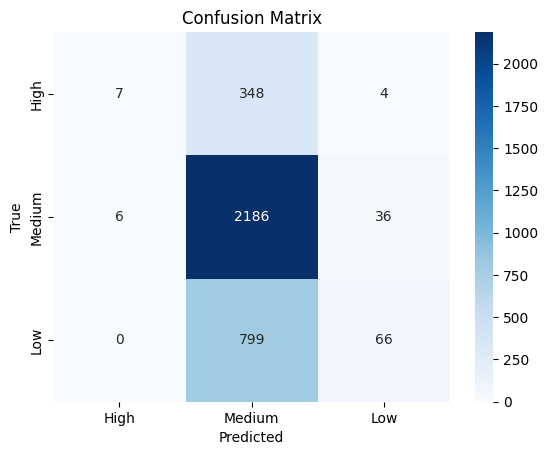

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Re-predict and evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["High", "Medium", "Low"], yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **Using GridSearchCV to Find the Best Hyperparameters**

**Grid Search on LinearSVC**

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define model with class balancing
svc = LinearSVC(class_weight='balanced', max_iter=5000)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10]  # regularization strength
}

# Wrap in GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit on training vectors (optionally SMOTE balanced)
grid_search.fit(X_train_vec, y_train)

# Best model
best_svc = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_svc.predict(X_test_vec)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.1}
              precision    recall  f1-score   support

        High       0.27      0.27      0.27       359
         Low       0.48      0.38      0.42       865
      Medium       0.70      0.76      0.73      2228

    accuracy                           0.62      3452
   macro avg       0.49      0.47      0.48      3452
weighted avg       0.60      0.62      0.61      3452



In [25]:
import joblib

joblib.dump(model, "priority_classifier_final.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_final.pkl")

['tfidf_vectorizer_final.pkl']